<a href="https://colab.research.google.com/github/james-monahan/Code-school-notebooks/blob/main/%20Project-3%20/syst%C3%A8me_de_recommandation_all_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
pd.set_option('mode.chained_assignment', None)


%matplotlib inline

##get data

In [ ]:
! wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# ! wget http://files.grouplens.org/datasets/movielens/ml-latest.zip

--2020-12-04 10:22:05--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.34MB/s    in 0.3s    

2020-12-04 10:22:06 (3.34 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
!wget https://datasets.imdbws.com/title.akas.tsv.gz
!wget https://datasets.imdbws.com/title.basics.tsv.gz 
!wget https://datasets.imdbws.com/title.ratings.tsv.gz 
!wget https://datasets.imdbws.com/title.crew.tsv.gz
!wget https://datasets.imdbws.com/name.basics.tsv.gz 

--2020-12-04 10:22:06--  https://datasets.imdbws.com/title.akas.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.224.10.26, 13.224.10.127, 13.224.10.27, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.224.10.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211022228 (201M) [binary/octet-stream]
Saving to: ‘title.akas.tsv.gz’

title.akas.tsv.gz   100%[===================>] 201.25M   179MB/s    in 1.1s    

2020-12-04 10:22:07 (179 MB/s) - ‘title.akas.tsv.gz’ saved [211022228/211022228]

--2020-12-04 10:22:07--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.224.10.26, 13.224.10.127, 13.224.10.27, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.224.10.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131603636 (126M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 125.51M   16

##IMBD and merge

In [ ]:
general = 'title.akas.tsv.gz'
basics = 'title.basics.tsv.gz'
crew = 'title.crew.tsv.gz'
names = 'name.basics.tsv.gz'

g_c = ['titleId', 'region', 'language']
df_general = pd.read_csv(general, usecols=g_c, delimiter='\t', encoding='utf-8', header=0, na_values=["\\N","nan"], compression='infer', low_memory=False)

b_c = ['tconst', 'isAdult', 'startYear',  'runtimeMinutes']
df_basics = pd.read_csv(basics, usecols=b_c, delimiter='\t', encoding='utf-8', header=0, na_values=["\\N","nan"], compression='infer', low_memory=False)

c_c = ['tconst', 'directors']
df_crew = pd.read_csv(crew, usecols=c_c, delimiter='\t', encoding='utf-8', header=0, na_values=["\\N","nan"], compression='infer', low_memory=False)

n_c = ['nconst', 'primaryName', 'primaryProfession','knownForTitles']
df_names = pd.read_csv(names, usecols=n_c, delimiter='\t', encoding='utf-8', header=0, na_values=["\\N","nan"], compression='infer', low_memory=False)


In [ ]:
ratings = 'title.ratings.tsv.gz'
df_ratings = pd.read_csv(ratings, delimiter='\t', encoding='utf-8', header=0, na_values=["\\N","nan"], compression='infer', low_memory=False)

In [ ]:
#limit to films france or english and drop any duplicates
mask = (df_general['region']=='FR') | (df_general['region']=='US')
#mask = df_general['region']=='US'
df_general = df_general[mask].drop_duplicates('titleId').reset_index(drop=True)
#df_general.drop_duplicates('tconst')['region'].value_counts()
#df_general['region'].value_counts()

In [ ]:
df_crew['directors'] = df_crew['directors'].fillna('missing')
df_crew['directors'] = df_crew['directors'].apply(lambda x: x.split(',')[0])

In [ ]:
df_ratings.shape, df_general.shape, df_basics.shape, df_crew.shape, df_names.shape

((1098295, 3), (4006775, 3), (7394693, 4), (7394693, 2), (10547298, 4))

In [ ]:
df_0 = pd.merge(df_basics, df_general, how='inner', left_on='tconst', right_on='titleId')

In [ ]:
df_1 = pd.merge(df_0, df_crew, how='inner', left_on='tconst', right_on='tconst')
df_1.drop('titleId', axis=1, inplace=True)

In [ ]:
df_2 = pd.merge(df_1, df_names, how='inner', left_on='directors', right_on='nconst')
df_2.drop(['directors', 'nconst', 'primaryProfession', 'knownForTitles'], axis=1, inplace=True)

In [ ]:
df_3 = pd.merge(df_2, df_ratings, how='inner', left_on='tconst', right_on='tconst')

In [ ]:
df_0.shape, df_1.shape, df_2.shape, df_3.shape

((4003344, 7), (4003344, 7), (2286081, 7), (429256, 9))

In [ ]:
df_3.sample(5)

,tconst,isAdult,startYear,runtimeMinutes,region,language,primaryName,averageRating,numVotes
216475,tt3467900,0,2017.0,90,US,NaN,Gabrielle Burton,6.2,26
35010,tt0136492,0,1935.0,57,US,NaN,Ray Nazarro,5.0,51
159200,tt0185154,0,1999.0,87,US,NaN,Ventura Pons,6.4,403
263123,tt5730352,0,2017.0,NaN,US,NaN,Rory Karpf,8.0,417
371234,tt1366754,0,1980.0,41,FR,fr,Hanns Christian Müller,8.3,6


#Movielens data and merge

In [ ]:
! unzip 'ml-latest-small.zip'

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
# ! unzip 'ml-latest.zip'

In [ ]:
#!cat ml-latest-small/README.txt

In [ ]:
links = 'ml-latest-small/links.csv'
tags = 'ml-latest-small/tags.csv'
ratings = 'ml-latest-small/ratings.csv'
movies = 'ml-latest-small/movies.csv'

# links = 'ml-latest/links.csv'
# tags = 'ml-latest/tags.csv'
# ratings = 'ml-latest/ratings.csv'
# movies = 'ml-latest/movies.csv'

In [ ]:
#df_tag = pd.read_csv(tags).drop('timestamp', axis=1)
#df_tag['timestamp'] = pd.to_datetime(df_tag['timestamp'], unit='s',  utc=True)
#df_tag.head(5)
#df_5 = pd.merge(df_ml, df_tag, on='userId', how='outer')

In [ ]:
#keys to merge data from other sources
#df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s',  utc=True)

df_links = pd.read_csv(links, encoding='utf-8', dtype='string').drop('tmdbId', axis=1)
df_ratings = pd.read_csv(ratings, encoding='utf-8').drop('timestamp', axis=1)
df_movies = pd.read_csv(movies, encoding = 'utf8')

In [ ]:
df_links.movieId = df_links.movieId.astype('int64')
df_ratings.movieId = df_ratings.movieId.astype('int64')
df_movies.movieId = df_movies.movieId.astype('int64')

In [ ]:
#investigate the other datasets
#!head /content/ml-latest/tags.csv

In [ ]:
df_links.shape, df_ratings.shape, df_movies.shape

((9742, 2), (100836, 3), (9742, 3))

In [ ]:
#sample from larger database
#df_ratings = df_ratings.sample(200000)

In [ ]:
print(df_links.dtypes) 
print(df_ratings.dtypes)
print(df_movies.dtypes)
print(df_ratings.dtypes)

movieId     int64
imdbId     string
dtype: object
userId       int64
movieId      int64
rating     float64
dtype: object
movieId     int64
title      object
genres     object
dtype: object
userId       int64
movieId      int64
rating     float64
dtype: object


In [ ]:
df_ml = df_movies.merge(df_ratings, left_on='movieId', right_on='movieId', how='inner')

In [ ]:
df_ml = df_ml.merge(df_links, left_on='movieId', right_on='movieId', how='inner')

In [ ]:
df_ml['imdbId']= df_ml['imdbId'].dropna().astype('string')

In [ ]:
df_ml.head()

,movieId,title,genres,userId,rating,imdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,0114709
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,0114709
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,0114709
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,0114709
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,0114709


In [ ]:
df_3['tconst'] = df_3['tconst'].apply(lambda x: x[-7:])

In [ ]:
df_ml.shape, df_3.shape

((100836, 6), (429256, 9))

In [ ]:
df_f_merge = pd.merge(df_ml, df_3, how='inner', left_on='imdbId', right_on='tconst')
df_f_merge = df_f_merge.drop(['imdbId'], axis=1)

In [ ]:
#df_f_merge[df_f_merge.language.isna()].sample(10)

In [ ]:
df_f_merge.language.fillna('en', inplace=True)
time_mean = df_f_merge.runtimeMinutes.dropna().astype('int64').mean()
df_f_merge.runtimeMinutes.fillna(time_mean, inplace=True)
df_f_merge.runtimeMinutes = df_f_merge.runtimeMinutes.astype('int64')

In [ ]:
df_f_merge.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'tconst', 'isAdult',
       'startYear', 'runtimeMinutes', 'region', 'language', 'primaryName',
       'averageRating', 'numVotes'],
      dtype='object')

In [ ]:
df_f_merge.columns = ['movieId', 'title', 'genres', 'userId', 'rating', 'tconst','isAdult',
       'startYear', 'runtimeMinutes', 'region', 'language', 'director', 'IMDBRating', 'IMBDVotes']

In [ ]:
df_f_merge.sample(5)

,movieId,title,genres,userId,rating,tconst,isAdult,startYear,runtimeMinutes,region,language,director,IMDBRating,IMBDVotes
36053,1835,City of Angels (1998),Drama|Fantasy|Romance,432,5.0,0120632,0,1998.0,114,US,en,Brad Silberling,6.7,112778
10751,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,588,3.0,0110357,0,1994.0,88,US,en,Roger Allers,8.5,930249
49666,2918,Ferris Bueller's Day Off (1986),Comedy,412,4.0,0091042,0,1986.0,103,US,en,John Hughes,7.8,318446
27354,1235,Harold and Maude (1971),Comedy|Drama|Romance,440,4.5,0067185,0,1971.0,91,US,en,Hal Ashby,7.9,70224
48924,2858,American Beauty (1999),Drama|Romance,105,5.0,0169547,0,1999.0,122,US,en,Sam Mendes,8.3,1060136


#Data Frames

In [ ]:
df = df_f_merge.copy()

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df['genres'] = df['genres'].apply(lambda x: x.split('|'))
df_dummies = pd.get_dummies(df['genres'].explode())
df_dummies = df_dummies.groupby(df_dummies.index).sum()

In [ ]:
df_flat = pd.merge(df, df_dummies, left_on=df.index, right_on=df_dummies.index)

In [ ]:
by_user = df.pivot_table(index='userId',columns='title',values='rating')
by_user.sample(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zapped! (1982),Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_avg_rating = df_flat.groupby('movieId', as_index=False)['rating'].mean()
df_rating_count = df_flat.groupby('movieId', as_index=False)['rating'].count()
df_ratings = pd.merge(df_avg_rating, df_rating_count, left_on=df_avg_rating.index, right_on=df_rating_count.index)
df_ratings = df_ratings.drop(['key_0',	'movieId_y'], axis=1)
df_ratings.columns=['movieId', 'Mean_rating', 'Total_ratings']
df_flat_review = df_flat.drop(['userId', 'rating'], axis=1)
df_flat_review = df_flat_review.drop_duplicates('movieId')
df_flat_review = pd.merge(df_ratings, df_flat_review, left_on='movieId', right_on='movieId')

In [ ]:
df_flat_review = df_flat_review.drop(['key_0', 'tconst', 'genres'], axis=1)

In [ ]:
df_flat_review.head(3)

,movieId,Mean_rating,Total_ratings,title,isAdult,startYear,runtimeMinutes,region,language,director,IMDBRating,IMBDVotes,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,3.920930,215,Toy Story (1995),0,1995.0,81,US,en,John Lasseter,8.3,876688,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,3.431818,110,Jumanji (1995),0,1995.0,104,US,en,Joe Johnston,7.0,304029,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,3.259615,52,Grumpier Old Men (1995),0,1995.0,101,US,en,Howard Deutch,6.7,23996,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#function to filter dataset
genres = [None, '(no genres listed)','Action','Adventure','Animation','Children',
'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX',
'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

languages = [None,'en', 'es', 'fr']
region = [None, 'US', 'FR']
top_directors = ['Woody Allen', 'Alfred Hitchcock', 'Steven Spielberg', 'Clint Eastwood',
       'Martin Scorsese', 'Ridley Scott', 'Ron Howard', 'Spike Lee',
       'Steven Soderbergh', 'Barry Levinson']

def df_for_ml(df = df, directors=-1, director_name = None, genre=None, runtime=-1, language =-1, adult=-1, region=None):
# directors -1 = all, or 1 as only having 1 movie, enter digit to limit by movie count, all others as None -2
# director_name, limits to one speceific director, leave as None otherwise
# genre = None = all, or select 1 from pulldown 
# runtime = None = all, or limit by duration, -1 will drop
# language = none = all, or drop down selection, 'exclude'
# adult=-1 = all or 0=NO, 1-Yes 
# region= None = all or 0=NO, 1-Yes 
  print(f"Shape start {df.shape}")
   #drop missing values
  df = df.dropna()
  #df['runtimeMinutes'] = df['runtimeMinutes'].astype('int64')
  if directors == -2:
    df = df.drop('director', axis=1)
  if directors > 1:
    directors_num = df['director'].value_counts()[:directors+1].index
    df['director'] = df['director'].apply(lambda x: np.nan if x not in directors_num else x) #i'm not sure about using None Here
    df = df.dropna()
    df = pd.get_dummies(data=df, columns=['director'], prefix='director')
  if directors == 1:
    directors_num = (df['director'].value_counts()==1).to_frame().replace(False, np.nan).dropna().index
    df['director'] = df['director'].apply(lambda x: np.nan if x not in directors_num else x) #i'm not sure about using None Here
    df = df.dropna()
    df = pd.get_dummies(data=df, columns=['director'], prefix='director')
  if directors == -1:
    df = pd.get_dummies(data=df, columns=['director'], prefix='director')
  if director_name:
    df = df[df['director']== director_name]
  if genre:
    genres.remove(genre)
    df = df.drop(genres, axis=1)
    df = df[df[genre]== 1]
  if runtime > 0:
    df = df[df['runtimeMinutes'] <= runtime]
  if runtime < 0:
    df = df.drop('runtimeMinutes', axis=1)
  if language == 'exclude':
    df = df.drop('language', axis=1)
  elif language != None:
    df = df[df['language'] == language]
  else:
    df = pd.get_dummies(data=df, columns=['language'], prefix='language')
  if adult == 0:
    df = df[df['isAdult'] == 0]
  if adult == 1:
    df = df[df['isAdult'] == 1]
  if adult == -1:
    df = pd.get_dummies(data=df, columns=['isAdult'], prefix='Adult')
  if region:
    df = df[df['region'] == region]
  else:
    df = pd.get_dummies(data=df, columns=['region'], prefix='region')
  print(f"Shape End {df.shape}")
  df.reset_index(inplace=True)

  return df

#Les bases de données à utiliser :

In [ ]:
# NEW_NAME = df.copy()
# NEW_NAME2 = df_flat_review.copy()
# NEW_NAME3 = by_user.copy()

In [ ]:
#df.to_csv('df.csv')
# df_flat_review.to_csv('df_flat_review.csv')
# from google.colab import drive
# by_user.to_csv('by_user.csv')
# drive.mount('/content/drive')

In [ ]:
genres = [None, '(no genres listed)','Action','Adventure','Animation','Children',
'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','IMAX',
'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
languages = [None,'en', 'es', 'fr']
region = [None, 'US', 'FR']
top_directors = ['Woody Allen', 'Alfred Hitchcock', 'Steven Spielberg', 'Clint Eastwood',
       'Martin Scorsese', 'Ridley Scott', 'Ron Howard', 'Spike Lee',
       'Steven Soderbergh', 'Barry Levinson']


df_no_dir = df_for_ml(df = df_flat_review, directors=-2, director_name = None, genre=None, runtime=-1, language =None, adult=-1, region=None)
df_dir = df_for_ml(df = df_flat_review, directors=-1, director_name = None, genre=None, runtime=-1, language =None, adult=-1, region=None)


Shape start (9469, 32)
Shape End (9469, 33)
Shape start (9469, 32)
Shape End (9469, 3942)


#Sample UI - Query DB, Query Recommendation

###User Interfaces

In [ ]:
#@title Sample UI

Sample = ['hjhjhjhj', 'jkhkjhkhjk', 'movie3kjkj']  #@param
Set_code_option = False #@param {type:"boolean"}
Sample_set_num_Outputs = 50 #@param {type:"number"}
Sample_adjust_parameter_selections = 20 #@param ["10", "20", "30"] {type:"raw"}

In [ ]:
#@title Top films by rating

Minimum_Number_Reviews = 200 #@param {type:"number"}
Number_of_films = 5 #@param {type:"number"}
Movie_Lens = 'Movie_Lens'
IMBD = 'IMBD'
Rating_data = Movie_Lens #@param ['Movie_Lens', 'IMBD'] {type:"raw"}

def top_by_rating(min_ratings, number_films, rater):
  display(df_flat_review.where(df_flat_review['Total_ratings']>min_ratings)
  .sort_values(ascending=False, by=[rater])
  [['Mean_rating',	'Total_ratings',	'title']].head(number_films))

if Rating_data == 'Movie_Lens':
  top_by_rating(Minimum_Number_Reviews, Number_of_films, rater='Mean_rating')

else:
  top_by_rating(Minimum_Number_Reviews, Number_of_films, rater='IMDBRating')

,Mean_rating,Total_ratings,title
273,4.429022,317.0,"Shawshank Redemption, The (1994)"
2203,4.272936,218.0,Fight Club (1999)
46,4.237745,204.0,"Usual Suspects, The (1995)"
221,4.231076,251.0,Star Wars: Episode IV - A New Hope (1977)
457,4.225000,220.0,Schindler's List (1993)


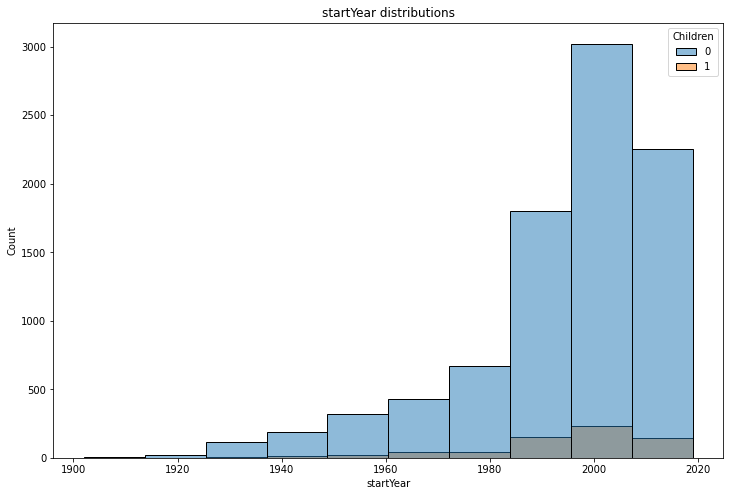

In [ ]:
#@title Plot Distributions
Mean_rating = 'Mean_rating' 
Total_ratings = 'Total_ratings'
Release_year = 'startYear'
Runtime = 'runtimeMinutes'
Region = 'region'
Language = 'language'

Set_number_bins = 10 #@param {type:"number"}
Data_to_plot = Release_year #@param ['Mean_rating', 'Total_ratings', 'Release_year', 'Runtime', 'Region', 'Language'] {type:"raw"}
Genre = "Children" #@param ["None", 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama','Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Log_Scale = False #@param {type:"boolean"}

def hist_plot(col=Data_to_plot, bins=Set_number_bins, hue=Genre, Log_Scale=Log_Scale):
  plt.figure(figsize = (12,8))
  sns.histplot(data = df_flat_review, x = col, 
               bins=bins, hue=hue,
               log_scale=Log_Scale).set_title(f'{col} distributions')

if Genre == "None":
  hist_plot(col=Data_to_plot, bins=Set_number_bins, hue=None, Log_Scale=Log_Scale)
else:
  hist_plot(Data_to_plot, Set_number_bins, Genre, Log_Scale)


plt.show()

In [ ]:
#@title Movie Statistics By Genre

aggs = {'movieId':'count', 'Mean_rating': 'mean', 'Total_ratings':'sum', 
'startYear':'mean', 'runtimeMinutes':'mean', 'director':'nunique',
'IMDBRating':'mean', 'IMBDVotes':'sum', 
'(no genres listed)':['sum', 'mean'], 'Action':['sum', 'mean'], 'Adventure':['sum', 'mean'],
'Animation':['sum', 'mean'], 'Children':['sum', 'mean'], 'Comedy':['sum', 'mean'], 
'Crime':['sum', 'mean'], 'Documentary':['sum', 'mean'], 'Drama':['sum', 'mean'],
'Fantasy':['sum', 'mean'], 'Film-Noir':['sum', 'mean'], 'Horror':['sum', 'mean'], 
'IMAX':['sum', 'mean'], 'Musical':['sum', 'mean'], 'Mystery':['sum', 'mean'],
'Romance':['sum', 'mean'], 'Sci-Fi':['sum', 'mean'], 'Thriller':['sum', 'mean'], 'War':['sum', 'mean'], 'Western':['sum', 'mean']}


by_decade = True #@param {type:"boolean"}
Genre = "Action" #@param ["None", 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama','Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']



def mean_genre(data = df_flat_review, genre = '(no genres listed)', by_decade=by_decade):
  if by_decade:
    data['startYear'] = data['startYear'].apply(lambda x: x//10*10)
    mask = data[genre]==1
    data = data[mask]
    return data.groupby([genre, 'startYear']).agg(aggs)
  else:
    mask = data[genre]==1
    data = data[mask]
    return data.groupby(genre).agg(aggs)

mean_genre(data = df_flat_review, genre = Genre, by_decade=by_decade)








movieId Mean_rating Total_ratings  ...       War Western          
         count        mean           sum  ...      mean     sum      mean
Action                                    ...                            
1         1805    3.094401         30703  ...  0.070914      42  0.023269

[1 rows x 48 columns]

In [ ]:
#@title Top Movies By Generation

Minimum_reviews = 20 #@param {type:"number"}
Number_movies = 3 #@param {type:"number"}
Generation = 1960 #@param {type:"slider", min:1900, max:2000, step:10}

def top_by_generation(min_reviews = Minimum_reviews, num=Number_movies):
  df_by_reviews = df_flat_review.loc[df_flat_review['Total_ratings']>min_reviews]
  df_by_reviews['startYear'] = df_by_reviews['startYear'].apply(lambda x: x//10*10)
  df_generations = df_by_reviews.groupby(['startYear'])['Mean_rating'].apply(lambda x: x.nlargest(num)).to_frame()
  df_generations.index.rename(['Generation','IDX'],inplace=True)
  firsts = df_generations.index.get_level_values('IDX')
  df_generations['movie_loc'] = firsts
  df_generations['title'] = df_generations['movie_loc'].apply(lambda x: df_flat_review.loc[x, 'title'])
  df_generations.drop('movie_loc', axis=1, inplace=True)


  if Generation == 1900:
    return df_generations
  else:
    return df_generations.loc[Generation]

top_by_generation(min_reviews = Minimum_reviews, num=Number_movies)

,Mean_rating,title
IDX,,
892,4.300000,Lawrence of Arabia (1962)
961,4.271930,Cool Hand Luke (1967)
595,4.268041,Dr. Strangelove or: How I Learned to Stop Worr...


In [ ]:
#@title Questionaire
Full_Name = "James Monahan" #@param {type:"string"}
Email_Address = "james@james.com" #@param {type:"string"}

Favorite_Genre = "Action" #@param ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama','Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Next_Favorite_Genre = "Musical" #@param ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama','Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
How_often_watch_movies = "Every Day" #@param ['Every Day', 'Often', 'Sometimes', 'Rarely']

Favorite_Movie = "Way of the Gun" #@param {type:"string"}

Sex = "Male" #@param ['Male', 'Female', 'Prefer Not to Say']
Age = 42 #@param {type:"integer"}
#age used to recomend movies from timeperiod

Consent_Terms_of_Service = True #@param {type:"boolean"}

person = {'Full_Name':[Full_Name], 'Email_Address':[Email_Address],
          'Favorite_Genre':[Favorite_Genre], 'Next_Favorite_Genre':[Next_Favorite_Genre],
          'How_often_watch_movies':[How_often_watch_movies],
          'Favorite_Movie':[Favorite_Movie], 'Sex':[Sex], 'Age':[Age], 
          'Consent':[Consent_Terms_of_Service]}


profile_df = pd.DataFrame.from_dict(person)
# print(profile_df)
# df = pd.DataFrame(person.values(), columns=person.keys())

#  {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
profile_df

,Full_Name,Email_Address,Favorite_Genre,Next_Favorite_Genre,How_often_watch_movies,Favorite_Movie,Sex,Age,Consent
0,James Monahan,james@james.com,Action,Musical,Every Day,Way of the Gun,Male,42,True


In [ ]:
#@title Get Movie

Movie_Name = "Pump" #@param {type:"string"}

def get_movie_name_idx(movie = Movie_Name):
  movie_index = df_dir[df_dir.title.str.contains(movie)].index
  print(df_dir.loc[movie_index][['title', 'Mean_rating', 'Total_ratings']])
  movie_index = movie_index[0]
  return movie_index

movie_index = get_movie_name_idx(movie = Movie_Name)
#print(movie_index)

                                             title  Mean_rating  Total_ratings
953                      Pump Up the Volume (1990)     3.611111              9
2843                            Pumpkinhead (1988)     2.400000              5
3836                                Pumpkin (2002)     3.000000              5
4776                           Pumping Iron (1977)     3.666667              3
6682  It's the Great Pumpkin, Charlie Brown (1966)     3.800000              5


In [ ]:
#@title Movie Recommendations

Movie_is_correct = True #@param {type:"boolean"}
Number_of_recommendations =  5#@param {type:"number"}
Distance = 2 #@param {type:"number"}

num = Number_of_recommendations+1

def find_neighbors(df, neighbors, movie, p):
  samples = df.drop(['movieId', 'title'], axis=1)
  scaler = StandardScaler()
  samples_scale = scaler.fit_transform(samples)
  neigh = NearestNeighbors(n_neighbors=neighbors, p=p)
  neigh.fit(samples_scale)
  movies = neigh.kneighbors(samples_scale[movie_index:movie_index+1, :], return_distance=False)
  
  remove1 = np.array([movies[0][1:]])
  [print(df.loc[x, ['title', 'Mean_rating', 'Total_ratings']]) for x in remove1]


if Movie_is_correct:
  find_neighbors(df = df_no_dir, neighbors = num, movie = movie_index, p=Distance)
else:
  print('Please Select Your Film')


                                             title  Mean_rating  Total_ratings
277                    Swimming with Sharks (1995)     3.550000             10
1379                          Smoke Signals (1998)     3.388889              9
928   Rosencrantz and Guildenstern Are Dead (1990)     3.968750             16
1100                               SubUrbia (1997)     3.750000              6
2275                        Peter's Friends (1992)     3.600000              5


#Model Predictions

In [ ]:
#Star Wars, Weekend at Bernies, 101 dalmations, Batman 
#Titanic, Friday the 13th, Casablanca, Mars Attacks, Gattaca, The Notebook
#Bring It On, Annie Hall, Princess Bride, Indiana Jones

In [ ]:
#check films by name for index
def get_movie_name_idx(movie):
  movie_index = df_dir[df_dir.title.str.contains(movie)].index
  print(df_dir.loc[movie_index][['title', 'Mean_rating', 'Total_ratings']])
  movie_index = movie_index[0]
  return movie_index

In [ ]:
movie_index = get_movie_name_idx('Pretty Woman')

                   title  Mean_rating  Total_ratings
509  Pretty Woman (1990)     3.485185            135


In [ ]:
def find_neighbors(df, neighbors, movie = movie_index, p=2):
  samples = df.drop(['movieId', 'title'], axis=1)
  scaler = StandardScaler()
  samples_scale = scaler.fit_transform(samples)
  neigh = NearestNeighbors(n_neighbors=neighbors, p=p)
  neigh.fit(samples_scale)
  movies = neigh.kneighbors(samples_scale[movie_index:movie_index+1, :], return_distance=False)
  print(movies)
  [print(df.loc[x, ['title', 'Mean_rating', 'Total_ratings']]) for x in movies]

In [ ]:
#with directors
find_neighbors(df = df_dir, neighbors = 5, movie = movie_index, p=2)

[[ 509 2025 5185 3146 1869]]
                          title  Mean_rating  Total_ratings
509         Pretty Woman (1990)     3.485185            135
2025       Runaway Bride (1999)     2.833333             42
5185           Overboard (1987)     3.000000              6
3146  Frankie and Johnny (1991)     2.833333              3
1869   Other Sister, The (1999)     3.333333              6


In [ ]:
#without directors
find_neighbors(df = df_no_dir, neighbors = 5, movie = movie_index, p=2)

[[509 293 468 298 379]]
                                 title  Mean_rating  Total_ratings
509                Pretty Woman (1990)     3.485185            135
293     While You Were Sleeping (1995)     3.469388             98
468        Sleepless in Seattle (1993)     3.471698            106
298  Ace Ventura: Pet Detective (1994)     3.040373            161
379                        Dave (1993)     3.546053             76


#Visualizations

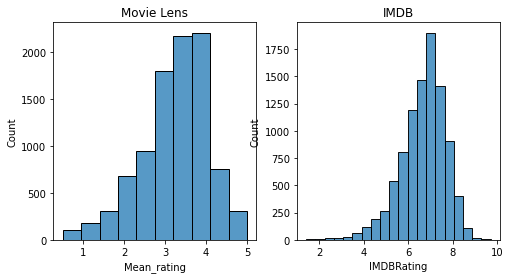

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(data = df_flat_review, x = 'Mean_rating', bins=10, ax=ax[0]).set_title('Movie Lens')
sns.histplot(data = df_flat_review, x = 'IMDBRating', bins=20,ax=ax[1]).set_title('IMDB')
plt.show()


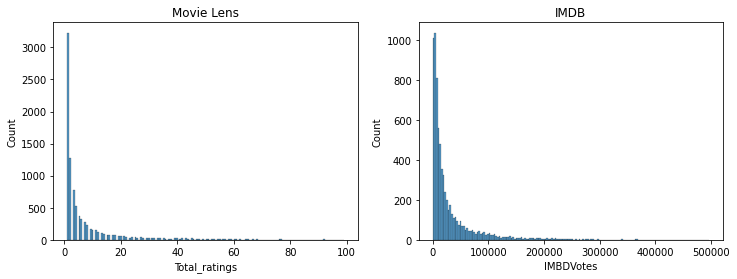

In [ ]:
#scaler_plot = StandardScaler()
#scaled_reviews = scaler_plot.fit_transform()
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data = df_flat_review.where(df_flat_review['Total_ratings']<100), x = 'Total_ratings', ax=ax[0], log_scale=False,).set_title('Movie Lens')
sns.histplot(data = df_flat_review.where(df_flat_review['Total_ratings']<10), x = 'IMBDVotes', ax=ax[1], log_scale=False).set_title('IMDB')
plt.show()

In [ ]:
#Top movies by mean rating, minimum value for total number of ratings
# display(df_flat_review.sort_values(ascending=False, by=['Total_ratings']).head())
# display(df_flat_review.sort_values(ascending=False, by=['IMBDVotes']).head())

display(df_flat_review.where(df_flat_review['Total_ratings']>250).sort_values(ascending=False, by=['Mean_rating']).head(1))
display(df_flat_review.where(df_flat_review['IMBDVotes']>2000).sort_values(ascending=False, by=['Mean_rating']).head(1))

,movieId,Mean_rating,Total_ratings,title,isAdult,startYear,runtimeMinutes,region,language,director,IMDBRating,IMBDVotes,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
273,318.0,4.429022,317.0,"Shawshank Redemption, The (1994)",0.0,1994.0,142.0,US,en,Frank Darabont,9.3,2312613.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,movieId,Mean_rating,Total_ratings,title,isAdult,startYear,runtimeMinutes,region,language,director,IMDBRating,IMBDVotes,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
7761,95311.0,5.0,1.0,Presto (2008),0.0,2008.0,5.0,FR,en,Doug Sweetland,8.3,22493.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


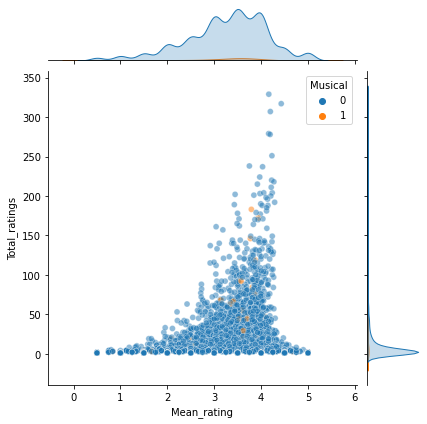

In [ ]:
#Rating to number ratings, with hue by genre (more ratings tends to be higher rated)
#use pull down to show by genre
sns.jointplot(x='Mean_rating',y='Total_ratings',data=df_flat_review,alpha=0.5, hue='Musical')

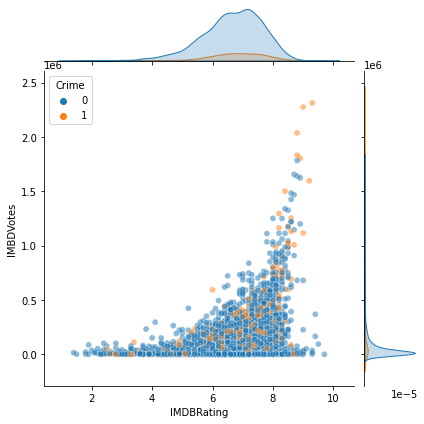

In [ ]:
#same but IMBD
sns.jointplot(x='IMDBRating',y='IMBDVotes',data=df_flat_review,alpha=0.5, hue='Crime')

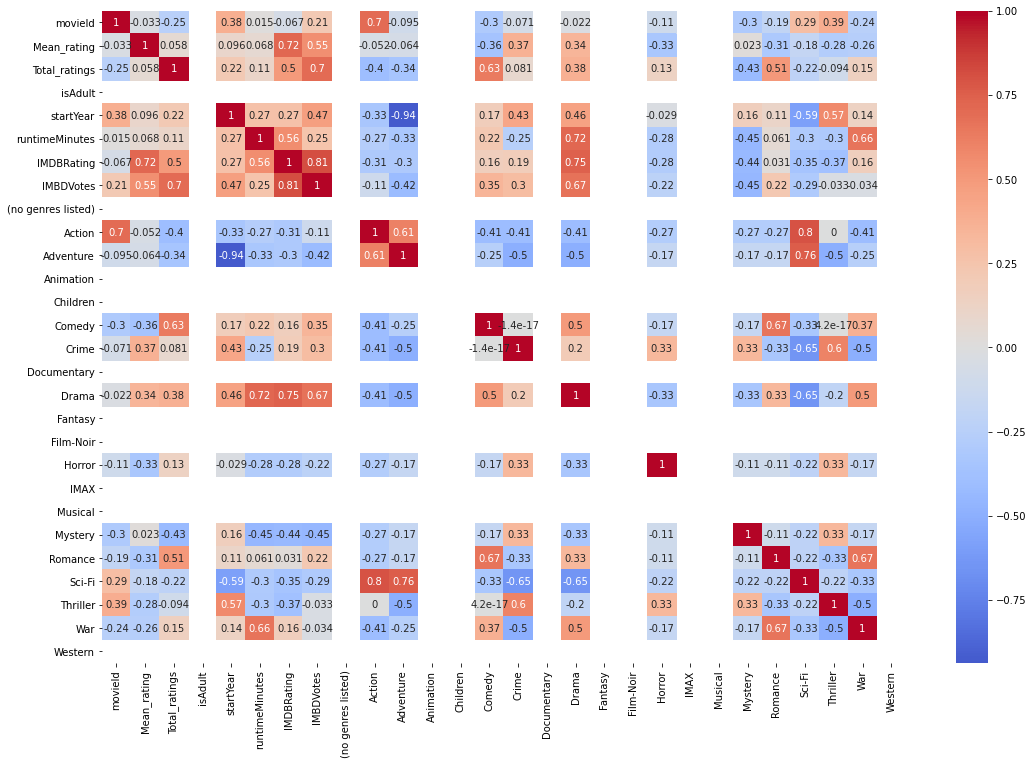

In [ ]:
#take highest rated movies, then plot corr heatmap
top_10 = df_flat_review.loc[df_flat_review['Total_ratings']>200].sort_values(ascending=False, by=['Mean_rating'])[:10]
#top_10 = df_flat_review.loc[df_flat_review['IMBDVotes']>200].sort_values(ascending=False, by=['IMDBRating'])[:10]

#top_10['runtimeMinutes'] = top_10['runtimeMinutes'].astype('int')
plt.figure(figsize=(18,12))
sns.heatmap(top_10.corr(), cmap='coolwarm', center=0, annot=True)
plt.show()

In [ ]:
aggs = {'movieId':'count', 'Mean_rating': 'mean', 'Total_ratings':'sum', 
'startYear':'mean', 'runtimeMinutes':'mean', 'director':'nunique',
'IMDBRating':'mean', 'IMBDVotes':'sum', 
'(no genres listed)':['sum', 'mean'], 'Action':['sum', 'mean'], 'Adventure':['sum', 'mean'],
'Animation':['sum', 'mean'], 'Children':['sum', 'mean'], 'Comedy':['sum', 'mean'], 
'Crime':['sum', 'mean'], 'Documentary':['sum', 'mean'], 'Drama':['sum', 'mean'],
'Fantasy':['sum', 'mean'], 'Film-Noir':['sum', 'mean'], 'Horror':['sum', 'mean'], 
'IMAX':['sum', 'mean'], 'Musical':['sum', 'mean'], 'Mystery':['sum', 'mean'],
'Romance':['sum', 'mean'], 'Sci-Fi':['sum', 'mean'], 'Thriller':['sum', 'mean'], 'War':['sum', 'mean'], 'Western':['sum', 'mean']}

In [ ]:

#Genre le plus apprécié
genre = ['(no genres listed)', 'Action', 'Adventure',
'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


def mean_genre(data = df_flat_review, genre = '(no genres listed)', by_decade=False):
  if by_decade:
    mask = data[genre]==1
    data = data[mask]
    data['startYear'] = data['startYear'].apply(lambda x: x//10*10)
    return data.groupby([genre, 'startYear']).agg(aggs)
  else:
    mask = data[genre]==1
    data = data[mask]
    return data.groupby(genre).agg(aggs)

mean_genre(data = df_flat_review, genre = 'War', by_decade=True)

movieId Mean_rating Total_ratings  ...  War Western          
                count        mean           sum  ... mean     sum      mean
War startYear                                    ...                       
1   1910.0          1    2.000000             1  ...    1       0  0.000000
    1920.0          2    3.825000            19  ...    1       0  0.000000
    1930.0          7    3.668535            91  ...    1       0  0.000000
    1940.0         17    3.625665            57  ...    1       0  0.000000
    1950.0         28    3.839543           169  ...    1       1  0.035714
    1960.0         40    3.787384           358  ...    1       3  0.075000
    1970.0         28    3.620010           333  ...    1       1  0.035714
    1980.0         47    3.509372           544  ...    1       1  0.021277
    1990.0         59    3.332232          1773  ...    1       2  0.033898
    2000.0        104    3.587773          1241  ...    1       2  0.019231
    2010.0         39    3.392334           264  ...    1       0  0.000000

[11 rows x 48 columns]

In [ ]:
#Directeur le plus apprécié
directors = df_flat_review.groupby('director').count().nlargest(5, 'movieId')#by number of films
#by mean rating with filter on ratings
directors = df_flat_review.loc[df_flat_review['Total_ratings']>200].groupby('director').mean().nlargest(5, 'Mean_rating')
directors

,movieId,Mean_rating,Total_ratings,isAdult,startYear,runtimeMinutes,IMDBRating,IMBDVotes,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
director,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Frank Darabont,318.0,4.429022,317.0,0.0,1994.0,142.0,9.3,2312613.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bryan Singer,50.0,4.237745,204.0,0.0,1995.0,106.0,8.5,980927.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
George Lucas,260.0,4.231076,251.0,0.0,1977.0,121.0,8.6,1217522.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Irvin Kershner,1196.0,4.215640,211.0,0.0,1980.0,124.0,8.7,1145695.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Quentin Tarantino,296.0,4.197068,307.0,0.0,1994.0,154.0,8.9,1804679.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Text(0.5, 1.0, 'Movie Lens Runtime Hist')

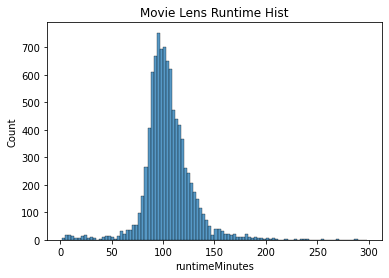

In [ ]:
max_minutes = df_flat_review[df_flat_review.runtimeMinutes<300]
sns.histplot(data = max_minutes, x = 'runtimeMinutes', bins=100).set_title('Movie Lens Runtime Hist')


In [ ]:
df_flat_review[df_flat_review.runtimeMinutes==680]

,movieId,Mean_rating,Total_ratings,title,isAdult,startYear,runtimeMinutes,region,language,director,IMDBRating,IMBDVotes,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
7676,93040,4.0,1,"Civil War, The (1990)",0,1990.0,680,US,en,Ken Burns,9.0,13414,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#highest rated by generation
df_by_reviews = df_flat_review.loc[df_flat_review['Total_ratings']>20]
df_by_reviews['startYear'] = df_by_reviews['startYear'].apply(lambda x: x//10*10)
idx = df_by_reviews.groupby('startYear')['Mean_rating'].transform(max) == df_by_reviews['Mean_rating']
df_by_reviews[idx].sort_values('startYear')

,movieId,Mean_rating,Total_ratings,title,isAdult,startYear,runtimeMinutes,region,language,director,IMDBRating,IMBDVotes,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1468,2010,3.857143,21,Metropolis (1927),0,1920.0,153,US,en,Fritz Lang,8.3,158410,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
691,919,3.880435,92,"Wizard of Oz, The (1939)",0,1930.0,102,US,en,Mervyn LeRoy,8.0,368984,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
670,898,4.310345,29,"Philadelphia Story, The (1940)",0,1940.0,112,FR,en,George Cukor,7.9,62814,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
694,922,4.333333,27,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),0,1950.0,110,US,en,Billy Wilder,8.4,199271,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
892,1204,4.300000,45,Lawrence of Arabia (1962),0,1960.0,228,US,en,David Lean,8.3,265083,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
650,858,4.289062,192,"Godfather, The (1972)",0,1970.0,175,US,en,Francis Ford Coppola,9.2,1596491,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
885,1197,4.232394,142,"Princess Bride, The (1987)",0,1980.0,98,US,en,Rob Reiner,8.0,390148,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
273,318,4.429022,317,"Shawshank Redemption, The (1994)",0,1990.0,142,US,en,Frank Darabont,9.3,2312613,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
6217,48516,4.252336,107,"Departed, The (2006)",0,2000.0,151,US,en,Martin Scorsese,8.5,1175359,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
9216,168252,4.280000,25,Logan (2017),0,2010.0,137,US,en,James Mangold,8.1,638426,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_by_reviews = df_flat_review.loc[df_flat_review['Total_ratings']>20]
df_by_reviews['startYear'] = df_by_reviews['startYear'].apply(lambda x: x//10*10)
df_generations = df_by_reviews.groupby(['startYear'])['Mean_rating'].apply(lambda x: x.nlargest(5)).to_frame()
df_generations.index.rename(['Generation','IDX'],inplace=True)
firsts = df_generations.index.get_level_values('IDX')
df_generations['movie_loc'] = firsts
df_generations['title'] = df_generations['movie_loc'].apply(lambda x: df_flat_review.loc[x, 'title'])
df_generations.drop('movie_loc', axis=1, inplace=True)
df_generations
#all or per generation

Mean_rating                                              title
Generation IDX                                                                 
1920.0     1468     3.857143                                  Metropolis (1927)
1930.0     691      3.880435                           Wizard of Oz, The (1939)
           941      3.804348                                   Duck Soup (1933)
           2562     3.720000                                Modern Times (1936)
           692      3.644444                          Gone with the Wind (1939)
           1750     3.640000                                   King Kong (1933)
1940.0     670      4.310345                     Philadelphia Story, The (1940)
           684      4.240000                                  Casablanca (1942)
           899      4.229167                              Third Man, The (1949)
           685      4.170455                         Maltese Falcon, The (1941)
           695      4.043478                                Citizen Kane (1941)
1950.0     694      4.333333      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
           676      4.261905                                 Rear Window (1954)
           697      4.229167                               All About Eve (1950)
           704      4.217391                            To Catch a Thief (1955)
           1405     4.187500                           On the Waterfront (1954)
1960.0     892      4.300000                          Lawrence of Arabia (1962)
           961      4.271930                              Cool Hand Luke (1967)
           595      4.268041  Dr. Strangelove or: How I Learned to Stop Worr...
           952      4.250000                   Manchurian Candidate, The (1962)
           1599     4.171875                             Rosemary's Baby (1968)
1970.0     650      4.289062                              Godfather, The (1972)
           921      4.288462                            Harold and Maude (1971)
           908      4.259690                     Godfather: Part II, The (1974)
           221      4.231076          Star Wars: Episode IV - A New Hope (1977)
           895      4.219626                              Apocalypse Now (1979)
1980.0     885      4.232394                         Princess Bride, The (1987)
           884      4.215640  Star Wars: Episode V - The Empire Strikes Back...
           919      4.212500                       Boot, Das (Boat, The) (1981)
           886      4.207500  Raiders of the Lost Ark (Indiana Jones and the...
           915      4.187500                                 Raging Bull (1980)
1990.0     273      4.429022                   Shawshank Redemption, The (1994)
           409      4.300000                   In the Name of the Father (1993)
           207      4.293103                                 Hoop Dreams (1994)
           2203     4.272936                                  Fight Club (1999)
           900      4.250000                                  Goodfellas (1990)
2000.0     6217     4.252336                               Departed, The (2006)
           6604     4.238255                            Dark Knight, The (2008)
           3586     4.183333  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
           4845     4.160305       Eternal Sunshine of the Spotless Mind (2004)
           6572     4.158537                                   In Bruges (2008)
2010.0     9216     4.280000                                       Logan (2017)
           7225     4.109091                                 Toy Story 3 (2010)
           7652     4.108108                                Intouchables (2011)
           7241     4.066434                                   Inception (2010)
           8300     4.050847                     Guardians of the Galaxy (2014)